## Downloading and Importing Relevant Libraries

!pip3 install numpy --quiet
!pip3 install pandas --quiet
!pip3 install yfinance --quiet
!pip3 install matplotlib --quiet 
!pip3 install scikit-learn --quiet 
!pip3 install tensorflow --quiet

In [175]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Downloading stock data for a particular ticker and timeframe.

In [176]:
ticker = "NVDA" 
start_date = "2010-01-01"
end_date = "2024-12-18"

nvda = yf.Ticker(ticker)
nvda = nvda.history(start=start_date)

nvda.index = pd.to_datetime(nvda.index)
nvda.index = nvda.index.date
nvda

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2010-01-04,0.424381,0.426903,0.415210,0.423923,800204000,0.0,0.0
2010-01-05,0.422318,0.434698,0.422318,0.430113,728648000,0.0,0.0
2010-01-06,0.429884,0.433781,0.425757,0.432864,649168000,0.0,0.0
2010-01-07,0.430571,0.432406,0.421171,0.424381,547792000,0.0,0.0
2010-01-08,0.420942,0.428279,0.418420,0.425298,478168000,0.0,0.0
...,...,...,...,...,...,...,...
2025-01-07,153.029999,153.130005,140.009995,140.139999,351782200,0.0,0.0
2025-01-08,142.580002,143.949997,137.559998,140.110001,227349900,0.0,0.0
2025-01-10,137.449997,139.919998,134.220001,135.910004,207602500,0.0,0.0
2025-01-13,129.990005,133.490005,129.509995,133.229996,204808900,0.0,0.0


## Visualizing the closing stock price of NVDA within our set time frame.

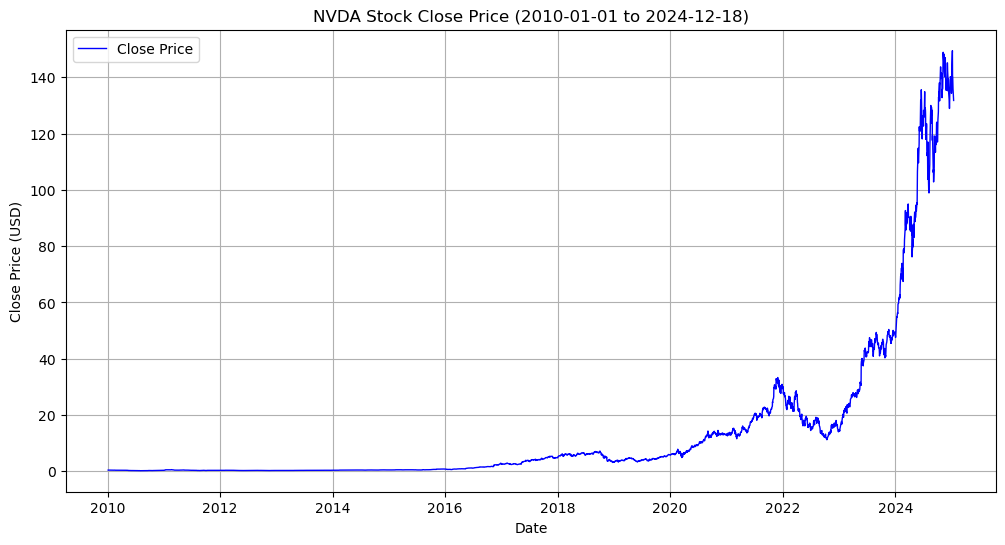

In [177]:
plt.figure(figsize=(12, 6))
plt.plot(nvda.index, nvda['Close'], color='blue', linewidth=1, label='Close Price')

# Add labels and title
plt.title(f"{ticker} Stock Close Price ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)

!pip install pandas_ta

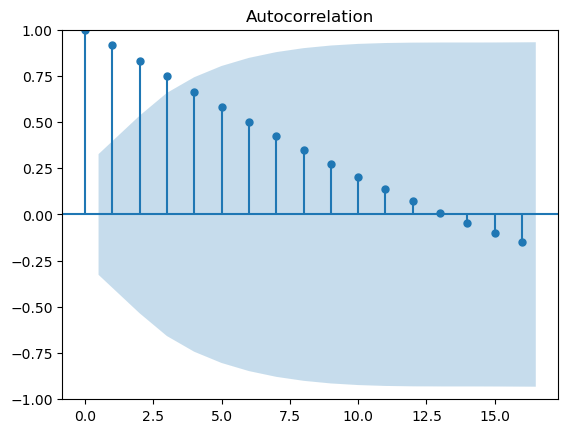

In [178]:
# nvda_sentiment_aggregated = pd.read_csv('nvda_sentiment_aggregated_new.csv')
# nvda_sentiment_aggregated.set_index('Date', inplace=True)

# nvda.index = pd.to_datetime(nvda.index)
# nvda_sentiment_aggregated.index = pd.to_datetime(nvda_sentiment_aggregated.index)

# nvda = nvda.join(nvda_sentiment_aggregated, how = "inner")
# nvda

from statsmodels.tsa.stattools import acf; from statsmodels.graphics import tsaplots
autocorrelation_function = acf(nvda["Close"].values)
fig = tsaplots.plot_acf(autocorrelation_function) 

In [179]:
# nvda['Rolling Sentiment_7'] = nvda['Net Sentiment Score'].rolling(window=7).mean()
# nvda['Rolling Sentiment_14'] = nvda['Net Sentiment Score'].rolling(window=14).mean()
# nvda['Rolling Sentiment_30'] = nvda['Net Sentiment Score'].rolling(window=30).mean()
# nvda['Daily_Return'] = nvda['Close'].pct_change()

def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate short-term (12) and long-term (26) EMAs
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    
    # Calculate MACD
    macd = short_ema - long_ema
    
    # Calculate signal line (9-day EMA of MACD)
    # signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    
    return macd

# Apply RSI and MACD to your 'Close' data
nvda['RSI'] = calculate_rsi(nvda['Close'])
nvda['MACD'] = calculate_macd(nvda['Close'])

def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Calculate the Exponential Moving Average (EMA)
def calculate_ema(data, window):
    return data['Close'].ewm(span=window, adjust=False).mean()

def daily_range(row):
    return row['Close'] - row['Open']

# nvda['Daily_Return'] = nvda.apply(daily_range, axis = 1)

def close_open_ratio(row):
    return row['Close'] / row['Open']

# nvda['Close-Open-Ratio'] = nvda.apply(close_open_ratio, axis = 1)

# # Rate of Change (ROC) over 7 and 14 days
nvda['ROC_7'] = nvda['Close'].pct_change(periods=7)
nvda['ROC_14'] = nvda['Close'].pct_change(periods=14)

# Momentum over 7 days
nvda['Momentum_7'] = nvda['Close'] - nvda['Close'].shift(7)

# Define the lookback windows for the moving averages
sma_window = 30  # 30-day Simple Moving Average
ema_window = 30  # 30-day Exponential Moving Average

# Add SMA and EMA to the dataframe
nvda['SMA'] = calculate_sma(nvda, sma_window)
nvda['EMA'] = calculate_ema(nvda, ema_window)

#Rolling Mean (7-day and 30-day)
nvda['Volume_7d_MA'] = nvda['Volume'].rolling(window=7).mean()
nvda['Volume_30d_MA'] = nvda['Volume'].rolling(window=30).mean()

#Rolling Standard Deviation (7-day)
nvda['Volume_7d_Std'] = nvda['Volume'].rolling(window=7).std()

nvda['Volume_Change_Pct'] = nvda['Volume'].pct_change()
nvda['High_Volume'] = (nvda['Volume'] > 1.5 * nvda['Volume_30d_MA']).astype(int)

nvda['Volume_to_Close_Ratio'] = nvda['Volume'] / nvda['Close']

#nvda['SMA_200'] = nvda['Close'].rolling(window=200).mean()

# Rolling Volatility (7-day and 30-day)
nvda['Volatility_7d'] = nvda['Close'].rolling(window=7).std()
nvda['Volatility_30d'] = nvda['Close'].rolling(window=30).std()

# Bollinger Bands (20-day Moving Average and Standard Deviation)
nvda['BB_Middle'] = nvda['Close'].rolling(window=20).mean()
nvda['BB_Upper'] = nvda['BB_Middle'] + (2 * nvda['Close'].rolling(window=20).std())
nvda['BB_Lower'] = nvda['BB_Middle'] - (2 * nvda['Close'].rolling(window=20).std())

# Deviation from Middle Band
nvda['BB_Deviation'] = (nvda['Close'] - nvda['BB_Middle']) / (2 * nvda['Close'].rolling(window=20).std())

# Drop NaN values
nvda = nvda.dropna()

In [180]:
correlation_matrix = nvda.corr()
correlation_matrix

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI,MACD,ROC_7,...,Volume_7d_Std,Volume_Change_Pct,High_Volume,Volume_to_Close_Ratio,Volatility_7d,Volatility_30d,BB_Middle,BB_Upper,BB_Lower,BB_Deviation
Open,1.000000,0.999867,0.999776,0.999573,-0.141570,0.062920,0.056764,0.063722,0.558542,0.070153,...,-0.188371,-0.028385,-0.050242,-0.301872,0.891062,0.911219,0.997059,0.997381,0.993707,0.049555
High,0.999867,1.000000,0.999789,0.999784,-0.140302,0.062803,0.057036,0.063918,0.557023,0.071008,...,-0.188021,-0.027332,-0.049052,-0.301999,0.892599,0.912426,0.997217,0.997668,0.993705,0.050385
Low,0.999776,0.999789,1.000000,0.999859,-0.143374,0.063352,0.056275,0.065859,0.560131,0.073222,...,-0.188966,-0.030307,-0.052234,-0.302215,0.889426,0.910792,0.996832,0.997050,0.993610,0.052865
Close,0.999573,0.999784,0.999859,1.000000,-0.142007,0.063202,0.057574,0.066208,0.558745,0.074312,...,-0.188589,-0.029324,-0.051196,-0.302207,0.890937,0.912017,0.996848,0.997224,0.993431,0.053754
Volume,-0.141570,-0.140302,-0.143374,-0.142007,1.000000,-0.034901,-0.010124,-0.025840,-0.052180,0.042678,...,0.654459,0.376209,0.522886,0.569370,-0.077763,-0.092813,-0.143918,-0.139675,-0.148723,-0.026999
Dividends,0.062920,0.062803,0.063352,0.063202,-0.034901,1.000000,-0.002202,0.027620,0.046370,0.017804,...,-0.010953,-0.033960,-0.020308,-0.049609,0.054829,0.073783,0.061508,0.064278,0.057910,0.018008
Stock Splits,0.056764,0.057036,0.056275,0.057574,-0.010124,-0.002202,1.000000,0.017917,0.113253,0.011109,...,-0.001562,-0.017818,-0.007050,-0.013393,0.064487,0.091971,0.051149,0.056965,0.043827,0.003965
RSI,0.063722,0.063918,0.065859,0.066208,-0.025840,0.027620,0.017917,1.000000,0.314997,0.649326,...,0.037662,0.013764,0.048971,-0.136717,0.041086,0.088615,0.033985,0.040472,0.025885,0.843950
MACD,0.558542,0.557023,0.560131,0.558745,-0.052180,0.046370,0.113253,0.314997,1.000000,0.235405,...,-0.046316,-0.010622,-0.006914,-0.147575,0.442127,0.655923,0.510359,0.522506,0.493867,0.260475
ROC_7,0.070153,0.071008,0.073222,0.074312,0.042678,0.017804,0.011109,0.649326,0.235405,1.000000,...,0.106660,0.009319,0.077662,-0.070377,0.085339,0.082643,0.039972,0.045266,0.033326,0.779982


<Axes: >

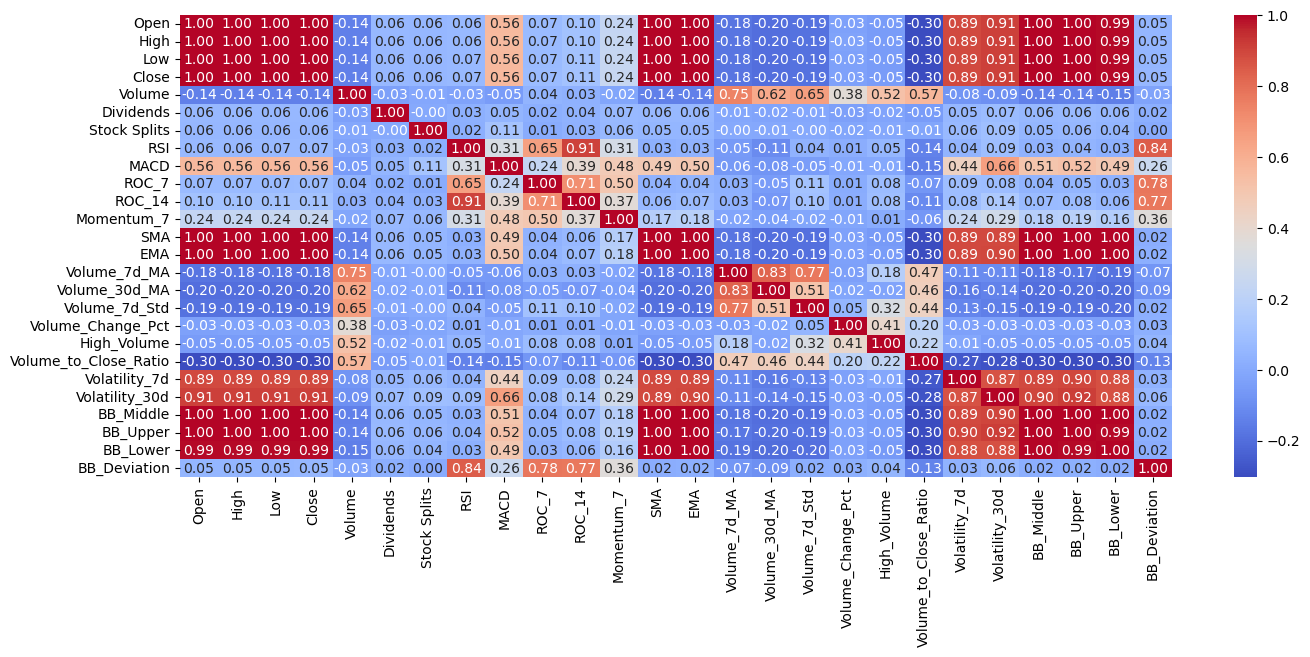

In [181]:
import seaborn as sns
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_matrix, annot= True, cmap = 'coolwarm', fmt = ".2f")

## Data Preprocessing
#### LSTMs are sensitive to the scale of the data. Therefore, we need to apply the MinMax Scalar.

In [182]:
# features = ['Close', 'MACD', 'RSI', 'Volume']
# features = ['Close(t-1)', 'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)',
#             'SMA', 'SMA_200', 'EMA', 'BB_Middle', 'BB_Upper', 'BB_Lower',
#             'RSI', 'Volatility_7d', 'Volatility_30d', 'Volume']

# features = ['Close', 'Volume', 'MACD', 'RSI']
#features = ['Close', 'RSI', 'MACD', 'Volume_Change_Pct', 'Momentum_7', 'Volatility_7d']

#features = ['Close', 'MACD']
# features = [
#     'Close',
#     'Volume_to_Close_Ratio',
#     'Signal_Line',
#     'Volume'
# ]

features = ['Close', 'Momentum_7']
# features = ['Close', 'MACD', 'RSI', 'Volume']

#features = nvda.columns.to_list()
num_features = len(features)
nvda_features = nvda[features]

In [183]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) # Initializes the scalar that scales values from 0 to 1 

In [184]:
# Splits the data into the training and testing set in a 65-35 split.

train_val_set = nvda_features[:int(0.7 * len(nvda_features))] 
test_set = nvda_features[int(0.7 * len(nvda_features)):]

training_val_scaled = scaler.fit_transform(train_val_set)
test_scaled = scaler.fit_transform(test_set)

In [185]:
training_scaled = training_val_scaled[:int(0.8 * len(training_val_scaled))]
val_scaled = training_val_scaled[int(0.8 * len(training_val_scaled)):]

In [186]:
def build_sequences(data, time_step):
    """Builds the time-step sequences to feed into the LSTM model."""
    X, Y = [], []
    for i in range(len(data) - time_step):
        input = data[i : i + time_step]
        target = data[i + time_step]

        X.append(input), Y.append(target)
    return np.array(X), np.array(Y)

In [187]:
time_step = 30

X_train, Y_train = build_sequences(training_scaled, time_step)
X_val, Y_val = build_sequences(val_scaled, time_step)
X_test, Y_test = build_sequences(test_scaled, time_step)

X_train

array([[[0.01961488, 0.56100173],
        [0.01999422, 0.56001535],
        [0.01738338, 0.55251885],
        ...,
        [0.01887848, 0.54660052],
        [0.01887848, 0.5443647 ],
        [0.01936941, 0.55001998]],

       [[0.01999422, 0.56001535],
        [0.01738338, 0.55251885],
        [0.01718255, 0.55278189],
        ...,
        [0.01887848, 0.5443647 ],
        [0.01936941, 0.55001998],
        [0.01952561, 0.55186125]],

       [[0.01738338, 0.55251885],
        [0.01718255, 0.55278189],
        [0.01724951, 0.55094067],
        ...,
        [0.01936941, 0.55001998],
        [0.01952561, 0.55186125],
        [0.01901237, 0.54850755]],

       ...,

       [[0.54132837, 0.63304042],
        [0.55594757, 0.7083432 ],
        [0.57911685, 0.71586639],
        ...,
        [0.6129854 , 0.58458744],
        [0.6125516 , 0.53196338],
        [0.6234204 , 0.56242952]],

       [[0.55594757, 0.7083432 ],
        [0.57911685, 0.71586639],
        [0.58325932, 0.72019529],
        .

#### Reshaping the data because an LSTM requires a 3D input shape: (number of samples, timesteps, number of features)

In [188]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], num_features)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], num_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], num_features)

In [189]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch
import keras_tuner

In [190]:
def lstm_model(hyper_params):
    model = Sequential()
    units = hyper_params.Int('units', min_value = 100, max_value = 200, step = 10)
    dropout_rate = hyper_params.Float('dropout_rate', min_value = 0.1, max_value = 0.3, step = 0.1)
    learning_rate = hyper_params.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model.add(layers.LSTM(units, return_sequences = True, input_shape = (None, num_features)))
    model.add(Dropout(dropout_rate))
    model.add(layers.LSTM(units, return_sequences = True))
    model.add(Dropout(dropout_rate))
    model.add(layers.LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss = 'mae', optimizer = optimizer, metrics=['accuracy'])

    return model

In [191]:
import keras_tuner as kt

tuner = kt.Hyperband(
    lstm_model,
    objective='val_accuracy',  # Minimize validation loss
    max_epochs=5,  
    directory='lstm-model',  # Directory to store the results
    project_name='lstm_tuning',  # Folder for storing this specific project
    overwrite=True,
)

# Callbacks for early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode = 'max', restore_best_weights=True)

# Fit the tuner
tuner.search(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), callbacks=[early_stopping])

Trial 10 Complete [00h 00m 25s]
val_accuracy: 0.002016128972172737

Best val_accuracy So Far: 0.0030241934582591057
Total elapsed time: 00h 03m 04s


In [192]:
# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [193]:
best_model = tuner.hypermodel.build(best_hyperparameters)
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, None, 110)      │        49,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 110)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, None, 110)      │        97,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, None, 110)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 110)            │        97,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 110)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,311 (954.34 KB)

 Trainable params: 244,311 (954.34 KB)

 Non-trainable params: 0 (0.00 B)

In [194]:
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode = 'min', restore_best_weights=True)
# model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100, batch_size=10, verbose=1, callbacks= [early_stopping])
# model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100, batch_size=10, verbose=1)
history = best_model.fit(X_train, Y_train, epochs=100, batch_size = 10, validation_data=(X_val, Y_val), verbose = 1, callbacks=[early_stopping])

Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 1.4247e-04 - loss: 0.2419 - val_accuracy: 0.0020 - val_loss: 0.1079
Epoch 2/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 4.6505e-05 - loss: 0.2331 - val_accuracy: 0.0020 - val_loss: 0.1050
Epoch 3/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 1.8796e-04 - loss: 0.2314 - val_accuracy: 0.0020 - val_loss: 0.1080
Epoch 4/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 4.5329e-04 - loss: 0.2326 - val_accuracy: 0.0020 - val_loss: 0.1119
Epoch 5/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 6.6754e-05 - loss: 0.2334 - val_accuracy: 0.0020 - val_loss: 0.1010
Epoch 6/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 1.1326e-04 - loss: 0.2313 - val_accuracy: 0.0020 - val_loss: 0.1027


In [195]:
# def lstm_predict(data):
#     # Reshape the data for LSTM (e.g., from (num_samples, features) to (num_samples, time_steps, features))
#     reshaped_data = data.reshape(data.shape[0], time_step, num_features)
#     return model.predict(reshaped_data)

In [196]:
# explainer = shap.Explainer(lstm_predict, X_train.reshape(X_train.shape[0], time_step * num_features))
# shap_values = explainer(X_train.reshape(X_train.shape[0], time_step * num_features), max_evals=2881)

In [197]:
# shap.summary_plot(shap_values, X_train.reshape(X_train.shape[0], time_step * num_features))

In [198]:
test_predict = best_model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


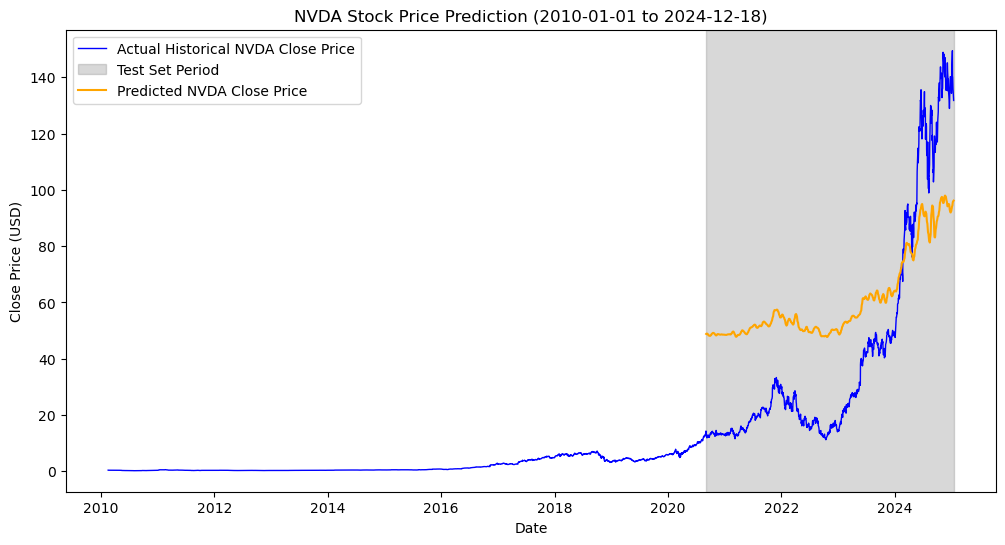

In [199]:
# Pad the test_predict and true test values to match the scaler's expected shape
test_predict_padded = np.zeros((test_predict.shape[0], scaler.n_features_in_))
test_predict_padded[:, 0] = test_predict[:, 0]  # Fill the "Close" predictions

y_test_padded = np.zeros((Y_test.shape[0], scaler.n_features_in_))
y_test_padded[:, 0] = Y_test[:, 0]  # Fill the true "Close" values

# Perform inverse transformation
test_predict_actual = scaler.inverse_transform(test_predict_padded)[:, 0]  # Extract the "Close" column
y_test_actual = scaler.inverse_transform(y_test_padded)[:, 0]  # Extract the "Close" column

test_dates = nvda.index[-len(y_test_actual):]

plt.figure(figsize=(12, 6))
plt.plot(nvda.index, nvda['Close'], color='blue', linewidth=1, label='Actual Historical NVDA Close Price')
plt.axvspan(test_dates[0], test_dates[-1], color='gray', alpha=0.3, label='Test Set Period')
plt.plot(test_dates, test_predict_actual, color = 'orange', label='Predicted NVDA Close Price')
plt.title(f'{ticker} Stock Price Prediction ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

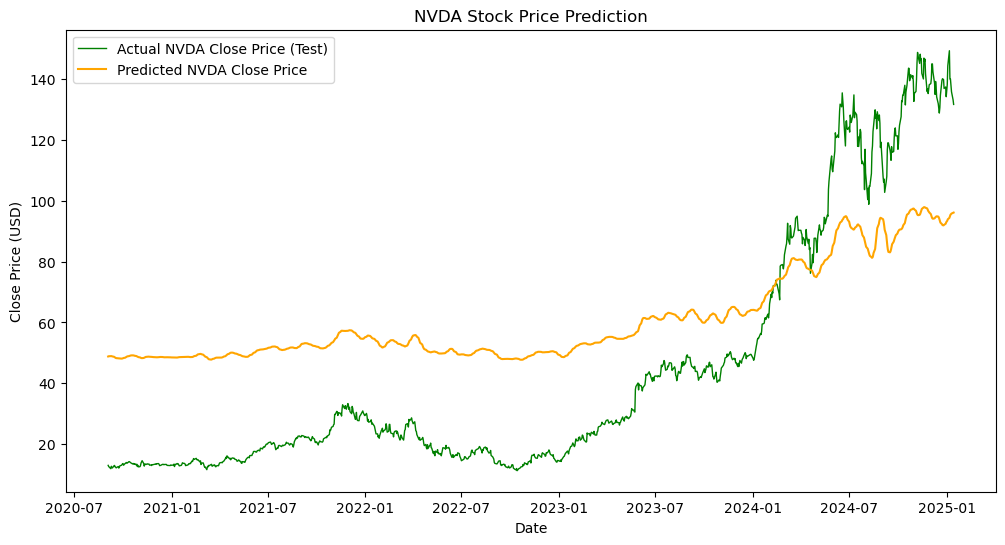

In [200]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, color='green', linewidth=1, label='Actual NVDA Close Price (Test)')
plt.plot(test_dates, test_predict_actual, color = 'orange', label='Predicted NVDA Close Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

In [201]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

print("Root Mean Squared Error: "+ str(root_mean_squared_error(y_test_actual, test_predict_actual)))
print("Mean Absolute Error: "+ str(mean_absolute_error(y_test_actual, test_predict_actual)))
print("R-Squared: "+ str(r2_score(y_test_actual, test_predict_actual)))
print("Mean Absolute Percentage Error: " + str(mean_absolute_percentage_error(y_test_actual, test_predict_actual)))

Root Mean Squared Error: 30.04445525396073
Mean Absolute Error: 28.484421370542382
R-Squared: 0.4284059800241089
Mean Absolute Percentage Error: 1.2751561302810173
